<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/Progetto_Lab_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Style Transfer & Genre Classification

Questo progetto si propone come obiettivo quello di *applicare uno stile musicale* di una fonte audio, che indicheremo come **style**, ad una seconda fonte audio, che chiameremo **content**. In sostanza vogliamo mantenere il contenuto della traccia *content* applicandole però lo stile della traccia *style*. In aggiunta intendiamo *classificare i generi musicali* di entrambe le fonti audio.

## Audio Style Transfer

Per raggiungere il primo obiettivo ci avvaliamo della tecnica di Neural Style Transfer come segue:
1. Trasformazione delle fonti audio in spettrogrammi
2. Applicazione del Neural Style Transfer
3. Trasformazione dello spettrogramma risultante in fonte audio

### Spettrogramma

Uno spettrogramma è la rappresentazione grafica dell'intensità di un suono in funzione del tempo e della frequenza.
* sull'asse delle ascisse è riportato il tempo in scala lineare
* sull'asse delle ordinate è riportata la frequenza in scala lineare o logaritmica
* a ciascun punto di data ascissa e data ordinata è assegnata una tonalità di grigio, o un colore, rappresentante l'intensità del suono in un dato istante di tempo e a una data frequenza

![](https://upload.wikimedia.org/wikipedia/commons/7/70/SpettrogrammaParolaManoColore.jpg)

## Genre Classification

# Dataset

## Audio Style Transfer

Operiamo su un totale di 11 fonti audio con le seguenti caratteristiche:

* Canale `mono`
* Frequenza di campionamento a `44.1 KHz`
* Durata `10 s`

## Genre Classification

Ci avvaliamo del dataset `GTZAN` scaricabile [qui](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). Tutte le fonti audio hanno le seguenti caratteristiche:
* Canale `mono`
* Frequenza di campionamento a `22.05 KHz`
* Durata `30 s`

Il dataset è strutturato come segue:
* in `genres_original` abbiamo 10 sottocartelle contenenti 100 fonti audio in formato `.wav` per ciascun genere
* in `images_original` abbiamo 10 sottocartelle contenenti i rispettivi spettrogrammi
* 2 file `.csv` contenenti le features delle fonti audio. Un file contiene per ogni brano (di 30 secondi) una media e una varianza calcolata su più features che possono essere estratte da un file audio. L'altro file ha la stessa struttura, ma prima le canzoni sono state suddivise in file audio di 3 secondi (aumentando in questo modo di 10 volte la quantità di dati che potremo fornire al nostro modello di classificazione)

# Setup

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import torch.nn as nn
import torch
from torch.nn import ReLU, Conv1d, Conv2d, AvgPool1d, AvgPool2d, Linear
import torch.optim as optim
import torchvision.transforms as transforms
import copy
from torch.autograd import Variable
import librosa
import gc; gc.collect()
import soundfile as sf

style_audio_name = 'inputs/usa.mp3'
content_audio_name = 'inputs/imperial.mp3'
output_name = 'outputs/output.wav'

# Utilities

Cominciamo a definire una serie di funzioni:
* `toSpectrogram` per ottenere lo spettrogramma di una fonte audio
* `plotSpectrogram` per stampare lo spettrogramma
* `play` per ascoltare la fonte audio

In [ ]:
def to_spectrogram(filepath):
  sample_rate, samples = wavfile.read(filepath)
  frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
  return frequencies, times, spectrogram

In [ ]:
def plot_spectrogram(frequencies, times, spectrogram):
  plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.show()

In [ ]:
def play(filepath):
  audio = Audio(filepath)
  display(audio)

Quindi testiamone il funzionamento

In [ ]:
filepath = style_audio_name
frequencies, times, spectrogram = to_spectrogram(filepath)
plot_spectrogram(frequencies, times, spectrogram)
play(filepath)

filepath = content_audio_name
frequencies, times, spectrogram = to_spectrogram(filepath)
plot_spectrogram(frequencies, times, spectrogram)
play(filepath)

NameError: ignored

# Funzioni di Loss

Per questo approccio individuiamo due funzioni di Loss:
1. Content Loss: minimizzarne il valore significa che la fonte audio in uscita suonerà in maniera simile alla fonte di contenuto
2. Stlye Loss: minimizzarne il valore significa che la fonte audio in uscita suonerà in maniera simile alla fonte di stile

Idealmente vorremmo che entrambe fossero minimizzate

## Content Loss

La funzione di Content Loss prende una matrice di input ed un matrice di contenuto che corrisponde alla fonte audio di contenuto. Quindi ritorna la distanza pesata $w_{CL} \cdot D^L_C(X,C)$ tra la matrice di input $X$ e la matrice di contenuto $C$. Implementiamo il tutto estendendo la classe `nn.Module` e sfruttando la funzione `nn.MSELoss`

In [ ]:
class ContentLoss(nn.Module):

  def __init__(self, target):
    # costruttore della classe nn.Module da cui deriviamo
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()# * weight
    #self.weight = weight
    self.criterion = nn.MSELoss()

  def forward(self, input):
    self.loss = self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

## Style Loss

Ovviamente vogliamo estrarre dalla fonte di stile solamente le features più importanti. Se ad esempio è presente una parte cantata a noi non interessa. Al contrario vogliamo estrarre solamente la parte 'melodica' con le sue proprietà quali timbro e tono. Dobbiamo allora ricorrere ad una Gram Matrix. Allora prendiamo una prima parte della matrice di input ed eseguiamo una `flatten` per rimuovere una buona parte delle informazioni audio. Ripetiamo lo stesso per un'altra parte della matrice di input. Eseguiamo quindi il prodotto scalare tra le matrici 'appiattite'

![](https://www.w3resource.com/w3r_images/numpy-manipulation-ndarray-flatten-function-image-1.png)

Ma perché scegliamo proprio il prodotto scalare? Perché fornisce una misura di quanto due matrici siano simili o meno. Infatti se le matrici sono fortemente simili tra di loro otterremo un risultato molto grande, al contrario se sono molto differenti tra di loro otterremo un risultato molto piccolo. Per cui, se per esempio la prima matrice 'appiattita' corrisponde all'intonazione e la seconda corrisponde al volume ed otteniamo un prodotto scalare elevato vorrà dire che quando il volume è alto anche l'intonazione è alta. Il prodotto scalare però può fornirci ovviamente numeri molto grandi. Allora li normalizziamo dividendo ogni elemento per il numero totale di elementi nella matrice

In [ ]:
class GramMatrix(nn.Module):

  def forward(self, input):
    # a = batch size (= 1)
    # b = numero di feature maps
    # (c, d) = dimensione di una feature map (N = c * d)
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    # calcoliamo la Gram Matrix
    G = torch.mm(features, features.t())
    # normalizziamo i valori della Gram Matrix
    # dividendo per il numero di elementi in ogni feature map
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = target.detach()# * weight
    #self.weight = weight
    self.gram = GramMatrix()
    self.criterion = nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    self.G = self.gram(input)
    #self.G.mul_(self.weight)
    self.loss = self.criterion(self.G, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

# Conversione da Wav a Matrice

Utilizzeremo `librosa` per convertire i nostri file `.wav` in matrici da poter passare a PyTorch. Eseguiamo una Short-Time Fourier Transform ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform))

In [ ]:
N_FFT = 2048 # window size

def read_audio_spectrum(filename):
  x, fs = librosa.load(filename)
  S = librosa.stft(x, N_FFT)
  p = np.angle(S)
  S = np.log1p(np.abs(S))
  return S, fs

style_audio, style_sr = read_audio_spectrum(style_audio_name)
content_audio, content_sr = read_audio_spectrum(content_audio_name)

N_FREQS = style_audio.shape[0]
N_SAMPLES = style_audio.shape[1]

if (content_sr != style_sr):
  raise 'Campionamento diverso tra le fonti audio'

style_audio = style_audio.reshape([1, 1, N_FREQS, N_SAMPLES])
content_audio = content_audio.reshape([1, 1, N_FREQS, N_SAMPLES])

if torch.cuda.is_available():
  style_float = Variable((torch.from_numpy(style_audio)).cuda())
  content_float = Variable((torch.from_numpy(content_audio)).cuda())
else:
  style_float = Variable((torch.from_numpy(style_audio)))
  content_float = Variable((torch.from_numpy(content_audio)))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# Rete Neurale Convoluzionale

Creiamo ora la nostra CNN. La rete che utilizziamo è poco profonda e si basa su 2 convoluzioni ed una ReLu tra di esse.
* Per prima cosa aggiungiamo il Content Loss per renderci conto di quanto siano vicini o distanti le fonti audio dal contenuto originale
* A seguire aggiungiamo una ReLU
* Aumentiamo il numero di step da `2500` a `20000`
* Rendiamo un po' più profonda la rete aggiungendo un layer di `Conv1d`. Dopo questo layer calcoliamo la Content Loss e la Style Loss

In [ ]:
N_FILTERS = 64

class CNNModel(nn.Module):
  def __init__(self, kernel):
    super(CNNModel, self).__init__()
    self.conv1 = Conv2d(in_channels = 1, out_channels = N_FILTERS, kernel_size = (1, 11), stride = 1, padding = 1)
    self.relu1 = ReLU()
    self.conv1.weight = torch.nn.Parameter(kernel)

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    return out

KERNEL_WIDTH = 11
KERNEL_HEIGHT = 1

std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, 1, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).float()
cnn = CNNModel(kernel)
if torch.cuda.is_available():
  cnn = cnn.cuda()

style_weight = 1000000
content_weight = 1

def get_style_model_and_losses(cnn, style_float, content_float = content_float):
  cnn = copy.deepcopy(cnn)
  style_losses = []
  content_losses = []
  # creiamo il modello
  model = nn.Sequential()
  # ci serve una Gram Matrix
  gram = GramMatrix()
  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()
  # aggiungiamo la conv1
  model.add_module('conv_1', cnn.conv1)
  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu1)
  # aggiungiamo lo style loss
  target_feature = model(style_float).clone()
  target_feature_gram = gram(target_feature)
  style_loss = StyleLoss(target_feature_gram)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  # aggiungiamo il content loss
  target = model(content_float).detach()
  content_loss = ContentLoss(target)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

# Eseguiamo lo Style Transfer

Utilizziamo l'ottimizzatore `optim.Adam`. Per ogni iterazione della rete calcoliamo Style Loss e Content Loss che a loro volta vengono utilizzate per calcolare i gradienti, i quali verranno poi moltiplicati per i Learning Rates per aggiornare infine la matrice di input

In [ ]:
input_float = content_float.clone()
# input_float = Variable(torch.randn(content_float.size())).type(torch.FloatTensor)

learning_rate_initial = 1e-4

def get_input_param_optimizer(input_float):
  input_param = nn.Parameter(input_float.data)
  # optimizer = optim.Adagrad([input_param], lr = learning_rate_initial, lr_decay = 0.0001, weight_decay = 0)
  optimizer = optim.Adam([input_param], lr = learning_rate_initial)
  # optimizer = optim.SGD([input_param], lr=learning_rate_initial)
	# optimizer = optim.RMSprop([input_param], lr=learning_rate_initial)
  # optimizer = optim.LBFGS([input_param]) # needs input_float to be .contiguous()
  return input_param, optimizer

num_steps = 100 # 10000

def run_style_transfer(cnn, \
                       style_float = style_float, \
                       content_float = content_float, \
                       input_float = input_float, \
                       num_steps = num_steps):
  print('Costruendo il modello per lo Style Transfer...')
  # model, style_losses = get_style_model_and_losses(cnn, style_float)
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_float, content_float)
  input_param, optimizer = get_input_param_optimizer(input_float)
  print('Ottimizzando...')
  run = [0]

  while run[0] <= num_steps:
    def closure():
      # correggiamo i valori dell'input aggiornato
      input_param.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_param)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 10 == 0: # 100
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      
      return style_score + content_score
    
    optimizer.step(closure)

  # ci assicuriamo che i valori siano compresi tra 0 e 1
  input_param.data.clamp_(0, 1)

  return input_param.data

output = run_style_transfer(cnn, style_float = style_float, content_float = content_float, input_float = input_float)

Costruendo il modello per lo Style Transfer...
Ottimizzando...
run [10]:
Style Loss: 0.001006 Content Loss: 0.000139

run [20]:
Style Loss: 0.001006 Content Loss: 0.000139

run [30]:
Style Loss: 0.001006 Content Loss: 0.000139

run [40]:
Style Loss: 0.001006 Content Loss: 0.000139

run [50]:
Style Loss: 0.001006 Content Loss: 0.000139

run [60]:
Style Loss: 0.001006 Content Loss: 0.000139

run [70]:
Style Loss: 0.001006 Content Loss: 0.000139

run [80]:
Style Loss: 0.001006 Content Loss: 0.000139

run [90]:
Style Loss: 0.001006 Content Loss: 0.000139

run [100]:
Style Loss: 0.001006 Content Loss: 0.000139



# Ricostruiamo la fonte audio

Dobbiamo infine ricostruire la fonte audio sfruttando l'inversa della STFT

In [37]:
if torch.cuda.is_available():
  output = output.cpu()

N_FFT = 2048
output = output.reshape([N_FREQS, N_SAMPLES]).numpy()
a = np.zeros_like(output)
a = np.exp(output) - 1

# ricostruiamo la fase
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
  S = a * np.exp(1j * p)
  x = librosa.istft(S)
  p = np.angle(librosa.stft(x, N_FFT))

#x = librosa.griffinlim(a)

sf.write(output_name, x, style_sr)

#frequencies, times, spectrogram = to_spectrogram(output_name)
#plot_spectrogram(frequencies, times, spectrogram)
#play(output_name)
display(Audio(output_name))

# Nuovo Modello

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import ReLU, Conv2d
import soundfile as sf
import warnings
import copy
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

[Aggiungi commento]

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

Estraiamo gli spettrogrammi e adeguiamo il numero di samples e canali della fonte *style* a quelli della fonte *content* con uno slicing

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES] # slicing

Visualizziamo gli spettrogrammi e mostriamo i player delle due tracce

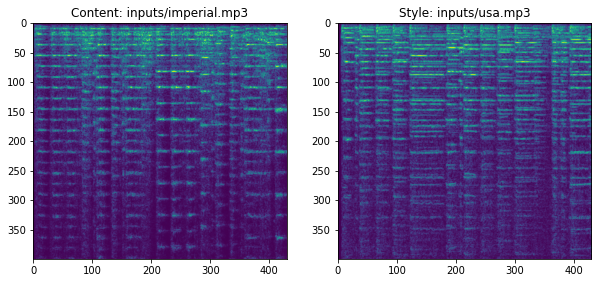

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

Definiamo il modello

In [ ]:
N_FILTERS = 4096
KERNEL_HEIGHT = 1
KERNEL_WIDTH = 11

class CNNModel(torch.nn.Module):

  def __init__(self, kernel):
    super().__init__()
    self.conv1 = Conv2d(in_channels = N_CHANNELS, 
                        out_channels = N_FILTERS, 
                        kernel_size = (11, 1))
    self.conv1.weight = torch.nn.Parameter(kernel)
    self.relu1 = ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    return out.detach()

In [ ]:
class GramMatrix(torch.nn.Module):

  def forward(self, features, samples):
    return np.matmul(features.T, features) / samples


class StyleLoss(torch.nn.Module):

  def __init__(self, target):
    super().__init__()
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    self.loss = 2 * self.criterion(self.output, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
class ContentLoss(torch.nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, alpha, input):
    self.loss = alpha * 2 * self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

Calcoliamo le features di stile e contenuto.
`std` è definita come $std=\sqrt{2} \cdot \sqrt{\frac{2}{(n_{channels}+n_{fitlers}) \cdot kernel\_width}}$ e fungerà da fattore moltiplicativo per il kernel

In [ ]:
# transponiamo e permutiamo per ottenere la shape giusta da passare in input
a_content_t = torch.from_numpy(np.ascontiguousarray(a_content.T[None,None,:,:])).permute(0, 3, 1, 2)
a_style_t = torch.from_numpy(np.ascontiguousarray(a_style.T[None,None,:,:])).permute(0, 3, 1, 2)
print('input size:', a_content_t.size(), '[batch, in_channels, in_height, in_width]')

# definiamo il nostro filtro
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, N_CHANNELS, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).float()
print('kernel size:', kernel.size(), '[kernel_batch, in_channels, kernel_height, kernel_width]')

# instanziamo la rete e la gram
cnn = CNNModel(kernel)
gram = GramMatrix()
if torch.cuda.is_available():
  cnn = cnn.cuda()
  gram = GramMatrix()

# calcoliamo le features
content_features = cnn(a_content_t)
print('content_features size:', content_features.size(), '[batch, out_channels, out_height, out_width]')
style_features = cnn(a_style_t)
print('style_features size:', style_features.size(), '[batch, out_channels, out_height, out_width]')

# ricaviamo la gram matrix
features = np.reshape(style_features, (-1, N_FILTERS))
print('style_features resize:', features.size(), '[out_height, out_channels]')
style_gram = gram(features, N_SAMPLES)
print('gram size:', style_gram.size())

input size: torch.Size([1, 1025, 1, 430]) [batch, in_channels, in_height, in_width]
kernel size: torch.Size([4096, 1025, 1, 11]) [kernel_batch, in_channels, kernel_height, kernel_width]
content_features size: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
style_features size: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
style_features resize: torch.Size([420, 4096]) [out_height, out_channels]
gram size: torch.Size([4096, 4096])


In [ ]:
ALPHA = 1e-2
learning_rate = 1e-3
iterations = 100
result = None

opt_tensor = torch.from_numpy(np.random.randn(1, N_CHANNELS, 1, N_SAMPLES).astype(np.float32) * 1e-3)
print('opt_tensor:', opt_tensor.size(), '[batch, in_channels, in_height, in_width]')
net = cnn(opt_tensor)
print('net:', net.size(), '[batch, out_channels, out_height, out_width]')

content_loss = ContentLoss(target = content_features)
style_loss = StyleLoss(target = style_gram)
if torch.cuda.is_available():
  content_loss = content_loss.cuda()
  style_loss = style_loss.cuda()
  

cl = content_loss(alpha = ALPHA, input = net)
print('cl:', cl.size())

number = net.size(1)
#height = net.size(2)
#width = net.size(3)

#size = height * width * number
feats = torch.reshape(net, (-1, number))
print('feats:', feats.size(), '[out_width, out_channels]')
feats_gram = gram(feats, N_SAMPLES)
print('feats_gram:', feats_gram.size())
sl = style_loss(input = feats_gram)
print('sl:', sl.size())

print(cl, sl)

#tl = cl + sl

opt_tensor: torch.Size([1, 1025, 1, 430]) [batch, in_channels, in_height, in_width]
net: torch.Size([1, 4096, 1, 420]) [batch, out_channels, out_height, out_width]
cl: torch.Size([1, 4096, 1, 420])
feats: torch.Size([420, 4096]) [out_width, out_channels]
feats_gram: torch.Size([4096, 4096])
sl: torch.Size([4096, 4096])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0083, 0.0085, 0.0069,  ..., 0.0072, 0.0063, 0.0069]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0011, 0.0017, 0.0000,  ..., 0.0000, 0.0007, 0.0015]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]]) tensor([[1.5149e-05, 1.4675e-05, 1.4614e-05,  ..., 4.7825e-06, 4.8418e-06,
         4.7718e-06],
        [1.4675e-05, 1.4946e-05, 1.4556e-05,  ..., 4.5644e-06, 4.6453e-06,
         4.5685e-06],
        [1.4614e-05, 1.4556e-05, 1.4885e-05,  ..., 4.7035e-06

In [ ]:
def get_style_model_and_losses(cnn, style_float, content_float = content_float, style_weight = style_weight):

  cnn = copy.deepcopy(cnn)

  style_losses = []
  content_losses = []

  # creiamo il modello
  model = nn.Sequential()

  # ci serve una Gram Matrix
  #gram = GramMatrix()

  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    #gram = gram.cuda()
  
  # aggiungiamo la conv1
  model.add_module('conv1', cnn.conv1)

  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu1)

  # aggiungiamo lo style loss
  target_feature = model(style_float).clone()
  target_feature_gram = gram(target_feature)
  style_loss = StyleLoss(target_feature_gram, style_weight)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  
  # aggiungiamo il content loss
  target = model(content_float).detach()
  content_loss = ContentLoss(target, content_weight)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

# Nuovo Modello riadattato

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import ReLU, Conv2d
import soundfile as sf
import warnings
import copy
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES] # slicing

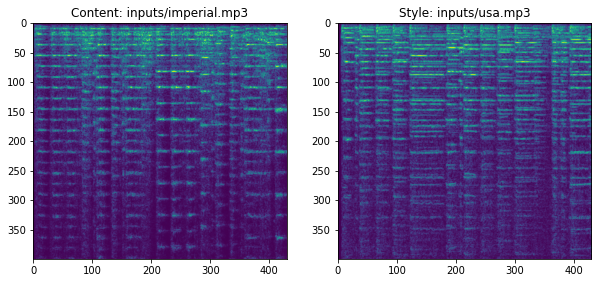

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

In [ ]:
N_FILTERS = 4096
KERNEL_HEIGHT = 1
KERNEL_WIDTH = 11

class CNNModel(torch.nn.Module):

  def __init__(self, kernel):
    super().__init__()
    self.conv1 = Conv2d(in_channels = N_CHANNELS, 
                        out_channels = N_FILTERS, 
                        kernel_size = (11, 1))
    self.conv1.weight = torch.nn.Parameter(kernel)
    self.relu1 = ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)

In [ ]:
class GramMatrix(torch.nn.Module):

  def forward(self, features, samples):
    g = torch.mm(features, features.t())
    return g.div(samples)


class StyleLoss(torch.nn.Module):

  def __init__(self, target):
    super().__init__()
    self.target = target.detach()
    self.gram = GramMatrix()
    self.criterion = torch.nn.MSELoss()

  def forward(self, input):
    self.output = input.clone()
    #input = np.reshape(input.detach(), (-1, N_FILTERS))
    self.G = self.gram(input, N_SAMPLES)
    self.loss = 2 * self.criterion(self.G, self.target)
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
class ContentLoss(torch.nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # facciamo una detach, necessaria per calolare dinamicamente il gradiente
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, alpha, input):
    self.loss = alpha * 2 * self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_graph=True):
    self.loss.backward(retain_graph=retain_graph)
    return self.loss

In [ ]:
def get_style_model_and_losses(cnn, a_style_t, a_content_t):
  cnn = copy.deepcopy(cnn)
  style_losses = []
  content_losses = []
  # creiamo il modello
  model = torch.nn.Sequential()
  # ci serve una Gram Matrix
  gram = GramMatrix()
  # carichiamo tutto sulla GPU
  if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()
  # aggiungiamo la conv1
  model.add_module('conv1', cnn.conv1)
  # aggiungiamo la relu
  model.add_module('relu1', cnn.relu1)
  # aggiungiamo lo style loss
  target_feature = model(a_style_t).clone()
  target_feature = np.reshape(target_feature.detach(), (-1, N_FILTERS))
  target_feature_gram = gram(target_feature, N_SAMPLES)
  style_loss = StyleLoss(target_feature_gram)
  model.add_module('style_loss_1', style_loss)
  style_losses.append(style_loss)
  # aggiungiamo il content loss
  print(a_content_t.shape)
  target = model(a_content_t).detach()
  content_loss = ContentLoss(target)
  model.add_module('content_loss_1', content_loss)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

In [ ]:
a_style_t = torch.from_numpy(a_style).reshape([1, N_CHANNELS, 1, N_SAMPLES])
a_content_t = torch.from_numpy(a_content).reshape([1, N_CHANNELS, 1, N_SAMPLES])

In [ ]:
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, N_CHANNELS, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).float()

cnn = CNNModel(kernel)

In [ ]:
# scegliere se cominciare ad iterare con la copia esatta del contenuto oppure con un tensore randomico
input_content_t = a_content_t.clone()
# input_float = Variable(torch.randn(content_float.size())).type(torch.FloatTensor)

learning_rate_initial = 1e-4

def get_input_param_optimizer(input_content_t):
  input_param = torch.nn.Parameter(input_content_t.data)
  # optimizer = optim.Adagrad([input_content_t], lr = learning_rate_initial, lr_decay = 0.0001, weight_decay = 0)
  optimizer = torch.optim.Adam([input_content_t], lr = learning_rate_initial)
  # optimizer = optim.SGD([input_content_t], lr=learning_rate_initial)
	# optimizer = optim.RMSprop([input_content_t], lr=learning_rate_initial)
  return input_param, optimizer

num_steps = 100 # 10000

def run_style_transfer(cnn, \
                       a_style_t = a_style_t, \
                       a_content_t = a_content_t, \
                       input_content_t = input_content_t, \
                       num_steps = num_steps):
  print('Costruendo il modello per lo Style Transfer...')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, a_style_t, a_content_t)
  input_param, optimizer = get_input_param_optimizer(input_content_t)
  print('Ottimizzando...')
  run = [0]

  while run[0] <= num_steps:
    def closure():
      # correggiamo i valori dell'input aggiornato
      #input_param.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_param)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        # print('sl vale ', sl, 'style loss vale', style_score)
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 10 == 0: # 100
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      
      return style_score + content_score
    
    optimizer.step(closure)

  # ci assicuriamo che i valori siano compresi tra 0 e 1
  #input_param.data.clamp_(0, 1)

  return input_param.data

In [ ]:
output = run_style_transfer(cnn, a_style_t = a_style_t, a_content_t = a_content_t, input_content_t = input_content_t)

Costruendo il modello per lo Style Transfer...
torch.Size([1, 1025, 1, 430])


RuntimeError: ignored

# Ancora nuovi test

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import ReLU, Conv2d
import soundfile as sf
import warnings
import copy
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_FREQS = a_content.shape[0]

a_style = a_style[:N_FREQS, :N_SAMPLES] # slicing

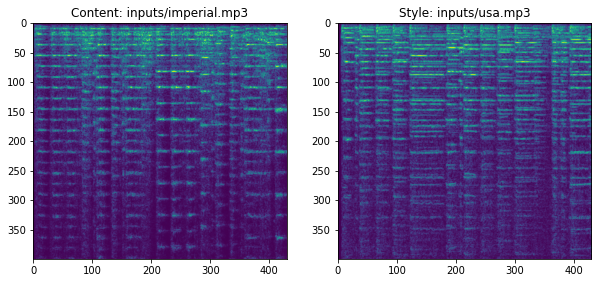

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

In [ ]:
class ContentLoss(torch.nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    self.criterion = torch.nn.MSELoss()

  def forward(self, input, alpha = 1e-2):
    self.loss = alpha * 2 * self.criterion(input, self.target)
    self.output = input
    return self.output

  def backward(self, retain_variables=True):
    self.loss.backward(retain_variables=retain_variables)
    return self.loss

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(torch.nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    self.criterion = torch.nn.MSELoss(size_average=False)

  def forward(self, input):
    self.output = input.clone()
    self.G = gram_matrix(input)
    self.loss = 2 * self.criterion(self.G, self.target)
    return self.output

  def backward(self, retain_variables=True):
    self.loss.backward(retain_graph=True)
    return self.loss

In [ ]:
a_style_t = torch.from_numpy(a_style).reshape([1, 1, N_FREQS, N_SAMPLES])
a_content_t = torch.from_numpy(a_content).reshape([1, 1, N_FREQS, N_SAMPLES])

In [ ]:
N_FILTERS = 4096
KERNEL_WIDTH = 11
KERNEL_HEIGHT = 1

std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQS + N_FILTERS) * KERNEL_WIDTH))
kernel = np.random.randn(N_FILTERS, 1, KERNEL_HEIGHT, KERNEL_WIDTH) * std
kernel = torch.from_numpy(kernel).type(torch.FloatTensor)

In [ ]:
class CNNModel(torch.nn.Module):
  def __init__(self, kernel):
    super(CNNModel, self).__init__()
    self.conv = Conv2d(in_channels = 1, out_channels = N_FILTERS, kernel_size = (KERNEL_WIDTH, KERNEL_HEIGHT))
    self.conv.weight = torch.nn.Parameter(kernel)
    self.relu = ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.relu(out)
    return out

In [ ]:
cnn = CNNModel(kernel)
if torch.cuda.is_available():
  cnn = cnn.cuda()

In [ ]:
def get_style_model_and_losses(cnn, a_style_t, a_content_t):
  '''
    Normalization Layer: see NST on Pytorch
  '''
  cnn = copy.deepcopy(cnn)
  style_losses = []
  content_losses = []
  # creiamo il modello sequenziale
  model = torch.nn.Sequential()
  # ci serve una Gram Matrix
  if torch.cuda.is_available():
    model = model.cuda()
  # aggiungiamo la conv1
  model.add_module('conv', cnn.conv)
  # aggiungiamo la relu
  model.add_module('relu', cnn.relu)
  # aggiungiamo lo style loss
  target_feature = model(a_style_t).clone()
  style_loss = StyleLoss(target_feature)
  model.add_module('style_loss', style_loss)
  style_losses.append(style_loss)
  # aggiungiamo il content loss
  print(a_content_t.shape)
  target = model(a_content_t).detach()
  content_loss = ContentLoss(target)
  model.add_module('content_loss', content_loss)
  print(model)
  content_losses.append(content_loss)

  return model, style_losses, content_losses

In [ ]:
a_input_t = torch.autograd.Variable(torch.randn(a_content_t.size()) * 1e-3).type(torch.FloatTensor)

learning_rate_initial = 1e-3

In [ ]:
def get_input_param_optimizer(a_input_t):
  input_param = torch.nn.Parameter(a_input_t.data)
  # optimizer = optim.Adagrad([a_input_t], lr = learning_rate_initial, lr_decay = 0.0001, weight_decay = 0)
  # optimizer = torch.optim.Adam([a_input_t], lr = learning_rate_initial)
  optimizer = torch.optim.LBFGS([a_input_t], lr = learning_rate_initial)
  # optimizer = optim.SGD([a_input_t], lr=learning_rate_initial)
	# optimizer = optim.RMSprop([a_input_t], lr=learning_rate_initial)
  return input_param, optimizer

In [ ]:
num_steps = 100 # 10000

In [ ]:
def run_style_transfer(cnn, a_style_t, a_content_t, a_input_t, num_steps):
  print('Costruendo il modello per lo Style Transfer...')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, a_style_t, a_content_t)
  input_param, optimizer = get_input_param_optimizer(a_input_t)
  print('Ottimizzando...')
  run = [0]

  while run[0] <= num_steps:
    def closure():
      # correggiamo i valori dell'input aggiornato
      #input_param.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_param)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 10 == 0: # 100
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      
      return style_score + content_score
    
    optimizer.step(closure)

  # ci assicuriamo che i valori siano compresi tra 0 e 1
  #input_param.data.clamp_(0, 1)

  return input_param.data

In [ ]:
output = run_style_transfer(cnn, a_style_t, a_content_t, a_input_t, num_steps)

Costruendo il modello per lo Style Transfer...


RuntimeError: ignored

In [ ]:
if torch.cuda.is_available():
  output = output.cpu()

output = output.reshape([N_CHANNELS, N_SAMPLES]).numpy()

N_FFT = 2048
a = np.zeros_like(output)
a = np.exp(output) - 1

# ricostruiamo la fase
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
  S = a * np.exp(1j * p)
  x = librosa.istft(S)
  p = np.angle(librosa.stft(x, N_FFT))

#x = librosa.griffinlim(a)

sf.write(OUTPUT_FILENAME, x, fs)

#frequencies, times, spectrogram = to_spectrogram(output_name)
#plot_spectrogram(frequencies, times, spectrogram)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

# Nuova sezione

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

import copy
import os
import math

import warnings
warnings.filterwarnings('ignore')

In [ ]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = False


In [ ]:
# set filenames
STYLE_FILENAME = "inputs/usa.mp3" #style filename
CONTENT_FILENAME = "inputs/imperial.mp3" #content filename
outname = 'outputs' #output dir

#librosa audio params
N_FFT = 2048

# architecture
"""use a custom convolutional network randomly initialized""" 
N_FILTERS = 4096 #no. of filters in 1st conv layer
hor_filter = 11 #width of conv filter, for 2d also the height of (square) kernel

In [ ]:
display(Audio(STYLE_FILENAME))
display(Audio(CONTENT_FILENAME))

In [ ]:
def read_audio_spectrogram(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [ ]:
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)

"""we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
#plt.ion()

N_SAMPLES = a_content.shape[1] #time bins
N_FREQ = a_content.shape[0] #freq bins

a_style = a_style[:N_FREQ, :N_SAMPLES] # slicing, in order to match lengths

a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]

a_content = np.ascontiguousarray(a_content[None,None,:,:])
a_content = torch.from_numpy(a_content)

style_img = Variable(a_style).type(dtype) #convert to pytorch variable
print("Style shape:",style_img.data.shape) #check shape is correct

content_img = Variable(a_content).type(dtype)
print("Content shape:",content_img.data.shape)

Style shape: torch.Size([1, 1, 1025, 430])
Content shape: torch.Size([1, 1, 1025, 430])


(1025, 430)


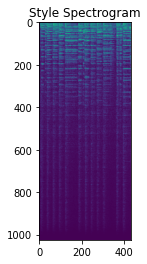

(1025, 430)


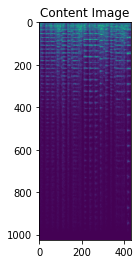

In [ ]:
def imshow(tensor, channels=1, title=None):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(N_FREQ,N_SAMPLES)  # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img.data, title='Style Spectrogram')

plt.figure()
imshow(content_img.data, title='Content Image')

In [ ]:
"Here we create the custom network"
import collections as c

IN_CHANNELS = 1

# custom weights initialization
def weights_init(m):
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQ + N_FILTERS) * hor_filter))
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, std)

class style_net(nn.Module):
    """Here create the network you want to use by adding/removing layers in nn.Sequential"""
    def __init__(self):
        super(style_net, self).__init__()
        self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(IN_CHANNELS,N_FILTERS,kernel_size=(1,hor_filter),bias=False)),
                            ('relu1',nn.ReLU()),
                            #('max1', nn.MaxPool2d(kernel_size=(1,2))),
                            ('conv2',nn.Conv2d(N_FILTERS,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
                            ('relu2',nn.ReLU())
                            ]))
        
    def forward(self,input):
        out = self.layers(input)
        return out
    
cnn = style_net()
cnn.apply(weights_init)
for param in cnn.parameters():
    param.requires_grad = False
print(cnn)

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

# Add the style/content loss 'layer' after the specified layer:

style_net(
  (layers): Sequential(
    (conv1): Conv2d(1, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False)
    (relu1): ReLU()
    (conv2): Conv2d(4096, 2048, kernel_size=(1, 11), stride=(1, 1), bias=False)
    (relu2): ReLU()
  )
)


In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [ ]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1
        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        #features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss(size_average=False)

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=True)
        return self.loss

In [ ]:
#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img=None,
                               style_weight=1, content_weight=0):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list = list(cnn.layers)
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()


    target = model(content_img).clone()
    target_feature = model(style_img).clone()
    target_feature_gram = gram(target_feature)


    model.add_module("conv1", cnn.layers.conv1)

    content_loss = ContentLoss(target, content_weight)
    model.add_module("content_loss_1", content_loss)
    content_losses.append(content_loss)

    style_loss = StyleLoss(target_feature_gram, style_weight)
    model.add_module("style_loss_1", style_loss)
    style_losses.append(style_loss)

    model.add_module("relu1", cnn.layers.relu1)

    model.add_module("conv2", cnn.layers.conv2)

    model.add_module("relu2", cnn.layers.relu2)
    

    for param in model.parameters():
        param.requires_grad = False
    
    return model, style_losses, content_losses

In [ ]:
"""image to input in generative network"""
#input_img = content_img.clone()

# if you want to use a white noise instead uncomment the below line:
input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

In [ ]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [ ]:
def run_style_transfer(cnn, style_img, input_img, content_img=None, num_steps=500,
                       style_weight=1, content_weight=0):
    """Run the style transfer"""
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    #print("Input range:",torch.max(input_param.data),torch.min(input_param.data))   
    print(model)
    print('Optimizing..')
    run = [0]
    
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            #if use01scale == True:
                #input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward() #call backward method to grab the loss

            for cl in content_losses:
                content_score += cl.backward()
            
            total_loss = style_score

            run[0] += 1
            
            if run[0] % 50 == 0:
                #print(torch.max(input_param.data),torch.min(input_param.data))
                
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.data[0]))
                print(torch.max(input_param.data),torch.min(input_param.data))
                print('Total Loss : {:4f}'.format(total_loss.data[0]))
                          
            return total_loss   
        
        optimizer.step(closure)
        
    # a last correction...
    #if use01scale == True:
        #input_param.data.clamp_(0, 1)

    return input_param.data

In [ ]:
output = run_style_transfer(cnn, style_img, input_img, content_img)
plt.figure()
out = imshow(output, title='Output Image')

plt.show()

Building the style transfer model..
Sequential(
  (conv1): Conv2d(1, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False)
  (content_loss_1): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu1): ReLU()
  (conv2): Conv2d(4096, 2048, kernel_size=(1, 11), stride=(1, 1), bias=False)
  (relu2): ReLU()
)
Optimizing..


# Nuova sezione 2

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

import copy
import os
import math

import warnings
warnings.filterwarnings('ignore')

In [ ]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = False


In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = "outputs/output.wav"

In [ ]:
hor_filter = 11

In [ ]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrogram(filename):
  x, fs = librosa.load(filename)
  S = librosa.stft(x, N_FFT)
  p = np.angle(S)
    
  S = np.log1p(np.abs(S[:,:430]))  
  return S, fs

In [ ]:
a_content, fs = read_audio_spectrogram(CONTENT_FILENAME)
a_style, fs = read_audio_spectrogram(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_FREQS = a_content.shape[0]

a_style = a_style[:N_FREQS, :N_SAMPLES] # slicing

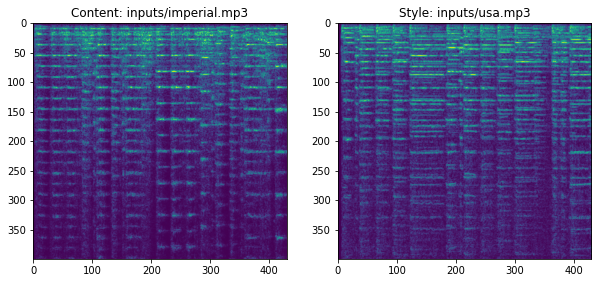

Content: inputs/imperial.mp3


Style: inputs/usa.mp3


In [ ]:
CONTENT_TITLE = 'Content: ' + CONTENT_FILENAME
STYLE_TITLE = 'Style: ' + STYLE_FILENAME

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(CONTENT_TITLE)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title(STYLE_TITLE)
plt.imshow(a_style[:400,:])
plt.show()

print(CONTENT_TITLE)
display(Audio(CONTENT_FILENAME))
print(STYLE_TITLE)
display(Audio(STYLE_FILENAME))

In [ ]:
a_style_t = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
a_style_t = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]

a_content_t = np.ascontiguousarray(a_content[None,None,:,:])
a_content_t = torch.from_numpy(a_content)

style_img = Variable(a_style_t).type(dtype) #convert to pytorch variable
print("Style shape:", style_img.data.shape) #check shape is correct

content_img = Variable(a_content_t).type(dtype)
print("Content shape:", content_img.data.shape)

Style shape: torch.Size([1025, 430])
Content shape: torch.Size([1025, 430])


In [ ]:
def imshow(tensor, channels=1, title=None):
  """ transforms pytorch tensor to numpy array and plots it out """
    
  image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
  image = image.view(N_FREQS, N_SAMPLES)  # remove the fake batch dimension
    
  image = image.numpy() #convert pytorch tensor to numpy array
  print(image.shape) #check shape
    
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

(1025, 430)


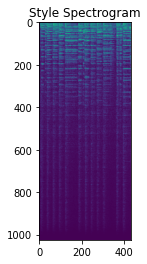

(1025, 430)


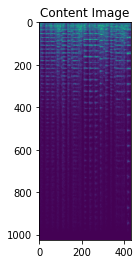

In [ ]:
plt.figure()
imshow(style_img.data, title='Style Spectrogram')

plt.figure()
imshow(content_img.data, title='Content Image')

In [ ]:
import collections as c

IN_CHANNELS = 1
N_FILTERS = 4096

class CNNModel(nn.Module):
  """Here create the network you want to use by adding/removing layers in nn.Sequential"""
  def __init__(self):
    super(CNNModel, self).__init__()
    self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1', nn.Conv2d(IN_CHANNELS, N_FILTERS, kernel_size = (1, hor_filter), bias = False)),
                            ('relu1', nn.ReLU()),
                            #('max1', nn.MaxPool2d(kernel_size = (1,2))),
                            ('conv2', nn.Conv2d(N_FILTERS, N_FILTERS//2, kernel_size = (1, hor_filter), bias = False)),
                            ('relu2', nn.ReLU())
                            ]))
        
  def forward(self,input):
    out = self.layers(input)
    return out

In [ ]:
cnn = CNNModel()
if use_cuda:
  cnn = cnn.cuda()

content_img = content_img.reshape([1, 1, N_FREQS, N_SAMPLES])

content_features = cnn(content_img)
print(content_features)

# Genre Classification

## Genre Classification via Image Augumentation

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor,transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.autonotebook import tqdm
from skimage.io import imread, imsave
%matplotlib inline

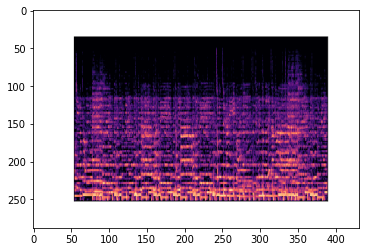

shape of image is: (288, 432, 4)


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img_path = "GTZAN Dataset/images_original"
img = mpimg.imread(img_path + '/rock/rock00093.png')
imgplot = plt.imshow(img)
plt.show()
print('shape of image is:', img.shape)

In [ ]:
batch_size = 32
im_size = (img.shape[0], img.shape[1])

In [ ]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

train_transforms = transforms.Compose([transforms.Resize(im_size),transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_loader)

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
train_transforms = transforms.Compose([transforms.Resize(im_size),
                                        transforms.RandomResizedCrop(size = 315, scale = (0.95, 1.0)),
                                        transforms.RandomRotation(degrees = 10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size = 299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
])
test_transforms = transforms.Compose([
                                        transforms.Resize(im_size),
                                        transforms.CenterCrop(size = 299),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
])

In [ ]:
#data loader
dataset = torchvision.datasets.ImageFolder(root = img_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = img_path, transform = test_transforms)

In [ ]:
#encoder and decoder to convert classes into integer
def encoder(data):
  #label of classes
  classes = data.classes
  encoder = {}
  for i in range(len(classes)):
    encoder[i] = classes[i]
  return encoder

def decoder(data):
  #label of classes
  classes = data.classes
    
  decoder = {}
  for i in range(len(classes)):
    decoder[classes[i]] = i
  return decoder

In [ ]:
#plotting random images from dataset
def class_plot(data,n_figures = 12):
  n_row = int(n_figures/4)
  fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
  for ax in axes.flatten():
    a = random.randint(0,len(data))
    (image,label) = data[a]
    #print(type(image))
    label = int(label)
    encoders = encoder(data)
    l = encoders[label]
    image = image.numpy().transpose(1,2,0)
    im = ax.imshow(image)
    ax.set_title(l)
    ax.axis('off')
  plt.show()

Prima dell'image augumentation

In [ ]:
class_plot(train_data)

Dopo l'image augumentation

In [ ]:
class_plot(dataset)

In [ ]:
torch.manual_seed(43)
val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(val_ds)

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class ClassifyMusic(nn.Module):

  def __init__(self,input_size,output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size,1024)
    self.linear2 = nn.Linear(1024,512)
    self.linear3 = nn.Linear(512,128)
    self.linear4 = nn.Linear(128,32)
    self.linear5 = nn.Linear(32,output_size)

  def forward(self, xb):
    out = xb.view(xb.size(0), -1)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    return out

  def training_step(self,batch):
    image,labels = batch
    out = self(image)
    loss = F.cross_entropy(out,labels)
    return loss
   
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    # Training Phase 
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
def plot_losses(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()

In [ ]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
        
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*299*299
output_size = 10

In [ ]:
model = to_device(ClassifyMusic(input_size,output_size), device)

In [ ]:
history = [evaluate(model, val_loader)]
print(history)

In [ ]:
# epochs = {0.1:50,0.01:50,0.001:50,0.0001:50}
epochs = {1e-2:50,1e-3:50,1e-5:50,1e-6:50}

In [ ]:
for lr,epoch in epochs.items():
    history += fit(epoch,lr, model, train_loader, val_loader)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
test = evaluate(model, test_loader)

In [ ]:
test_acc = test['val_acc']
test_loss = test['val_loss']
print(test_loss, test_acc)

In [ ]:
torch.save(model.state_dict(), 'genre-classification.pth')

In [ ]:
model = ClassifyMusic(input_size, output_size)
model.load_state_dict(torch.load('genre-classification.pth'))
model.eval()

ClassifyMusic(
  (linear1): Linear(in_features=268203, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
)

[Altre Metriche]

[Tentare altro approccio sfruttando le features nei file .csv]

## Genre Classification via .csv features

In [281]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [283]:
df = pd.read_csv('GTZAN Dataset/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [284]:
print("Il dataset ha dimensione",df.shape)
print("Resoconto dei samples positivi e negativi")
df.label.value_counts().reset_index()

Il dataset ha dimensione (9990, 60)
Resoconto dei samples positivi e negativi


index  label
0      blues   1000
1       jazz   1000
2      metal   1000
3        pop   1000
4     reggae   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

In [285]:
audio_fp = 'GTZAN Dataset/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

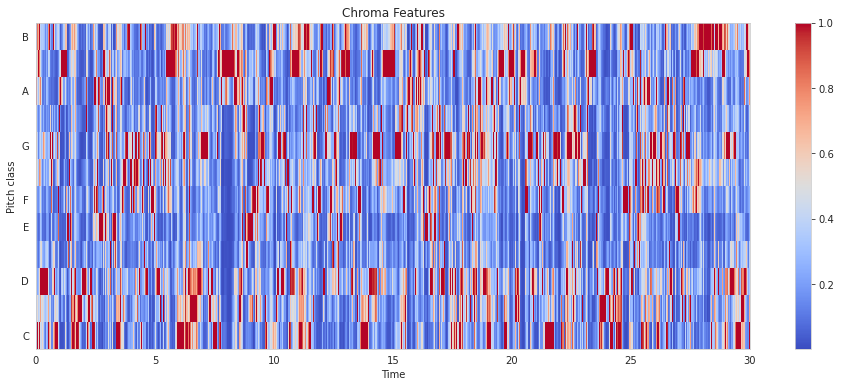

In [286]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

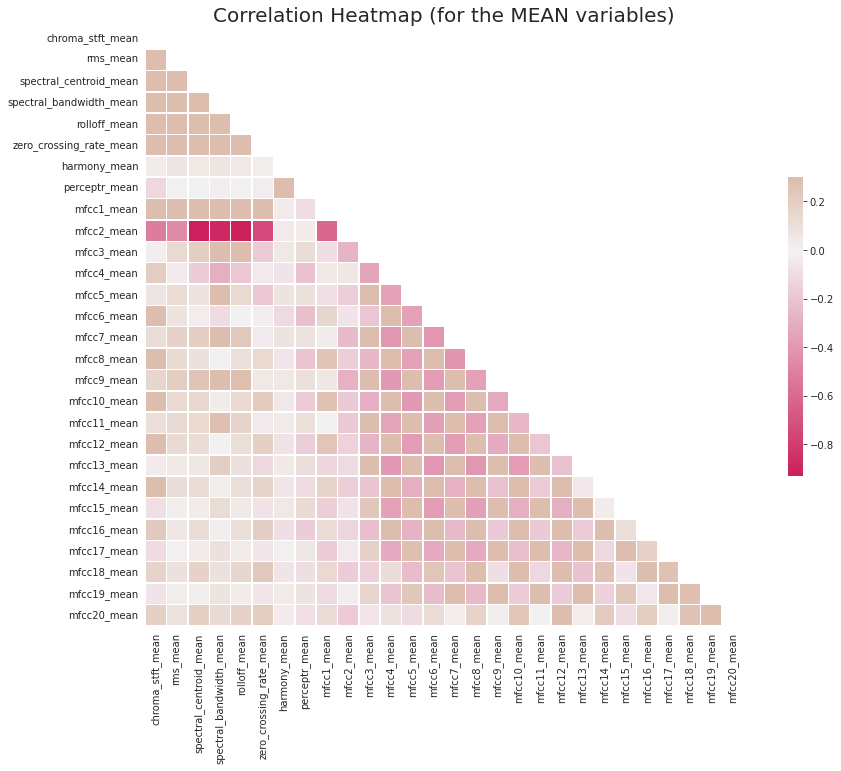

In [287]:
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

Text(0, 0.5, 'BPM')

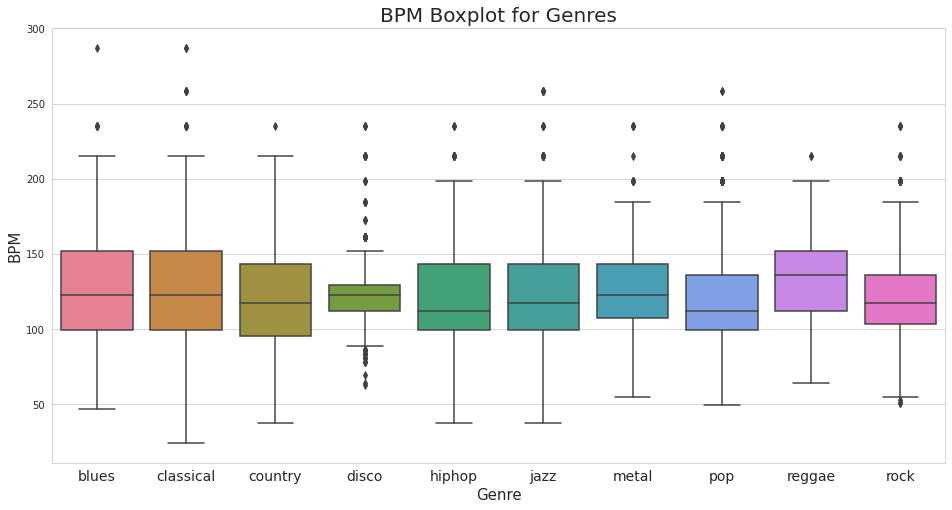

In [288]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

Text(0, 0.5, 'Principal Component 2')

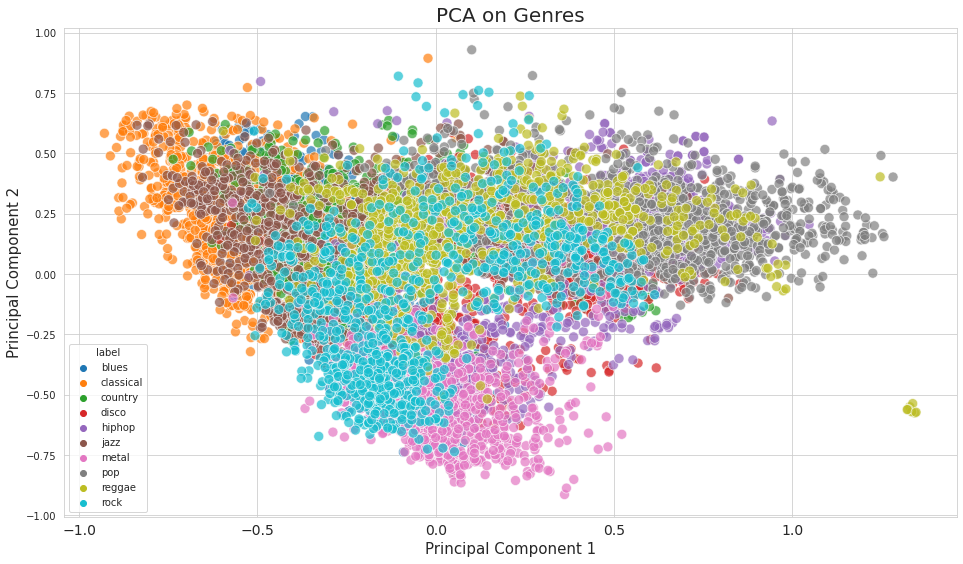

In [289]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

In [290]:
print("Le colonne con valori NA sono",list(df.columns[df.isnull().any()]))

Le colonne con valori NA sono []


In [291]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [292]:
df.label = [label_index[l] for l in df.label]

In [293]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [294]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [295]:
print(f"Il Train set ha {X_train.shape[0]} records su {len(df_shuffle)} che rappresenta il {round(X_train.shape[0]/len(df_shuffle)*100)}% del totale")
print(f"Il Dev set ha {X_dev.shape[0]} records su {len(df_shuffle)} che rappresenta il {round(X_dev.shape[0]/len(df_shuffle)*100)}% del totale")
print(f"Il Test set ha {X_test.shape[0]} records su {len(df_shuffle)} che rappresenta il {round(X_test.shape[0]/len(df_shuffle)*100)}% del totale")

Il Train set ha 6993 records su 9990 che rappresenta il 70% del totale
Il Dev set ha 1978 records su 9990 che rappresenta il 20% del totale
Il Test set ha 1019 records su 9990 che rappresenta il 10% del totale


In [296]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


In [297]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(seed)

In [299]:
class Model1(nn.Module):
  # 70 epochs, Adam
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 64)
    self.linear4 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = self.linear1(X_train)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.softmax(out)
    return out

In [300]:
class Model2(nn.Module):
  # 100 epochs, Adam
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.linear4 = nn.Linear(128, 64)
    self.linear5 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = self.linear1(X_train)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.linear2(out)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.linear3(out)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.linear4(out)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.linear5(out)
    out = F.softmax(out)
    return out

In [301]:
# [cancellabile]

class Model3(Model2):
  # 700 epochs, sgd
  def __init__(self, input_shape):
    super().__init__(input_shape)

In [302]:
class Model4(nn.Module):
  # 500 epochs, rmsprop
  def __init__(self, input_shape):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 256)
    self.linear4 = nn.Linear(256, 128)
    self.linear5 = nn.Linear(128, 64)
    self.linear6 = nn.Linear(64, 10)

  def forward(self, X_train):
    out = self.linear1(X_train)
    out = F.relu(out)
    out = F.dropout(out, 0.3)
    out = self.linear2(out)
    out = F.relu(out)
    out = F.dropout(out, 0.3)
    out = self.linear3(out)
    out = F.relu(out)
    out = F.dropout(out, 0.3)
    out = self.linear4(out)
    out = F.relu(out)
    out = F.dropout(out, 0.3)
    out = self.linear5(out)
    out = F.relu(out)
    out = F.dropout(out, 0.3)
    out = self.linear6(out)
    out = F.softmax(out)
    return out

In [303]:
# [TF code to translate]

ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

NameError: ignored

In [445]:
class MyDataset(torch.utils.data.Dataset):
 
  def __init__(self, X_df, y_df):
    self.X_df = torch.tensor(X_df.values, dtype=torch.float32)
    self.y_df = torch.tensor(y_df.values, dtype=torch.float32).type(torch.LongTensor)
 
  def __len__(self):
    return len(self.X_df)
   
  def __getitem__(self, idx):
    return self.X_df[idx], self.y_df[idx]

In [446]:
trainset = MyDataset(X_train, y_train)
devset = MyDataset(X_dev, y_dev)
testset = MyDataset(X_test, y_dev)

In [451]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 128,
                                          shuffle = True, num_workers = 2)
dev_loader = torch.utils.data.DataLoader(devset, batch_size = 128,
                                          shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 128,
                                         shuffle = False, num_workers = 2)

In [455]:
criterion = nn.CrossEntropyLoss()

In [478]:
def trainModel(model, epochs, optimizer):
  for e in range(epochs):
    train_loss = 0.0
    train_correct = 0
    for i, train_data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        train_inputs, train_labels = train_data
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_inputs)
        # Find the Loss
        loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        # Calculate correct
        #train_correct += (train_outputs == train_labels).float().sum()

     
    dev_loss = 0.0
    dev_correct = 0
    model.eval()     # Optional when not using Model Specific layer
    for i, dev_data in enumerate(dev_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        dev_inputs, dev_labels = dev_data
        # Forward Pass
        dev_outputs = model(dev_inputs)
        # Find the Loss
        loss = criterion(dev_outputs, dev_labels)
        # Calculate Loss
        dev_loss += loss.item()
        # Calculate correct
        #dev_correct += (dev_outputs == dev_labels).float().sum()

    #train_accuracy = 100 * train_correct / len(trainset)
    #dev_accuracy = 100 * dev_correct / len(trainset)
 
    print(f'Epoch {e+1}/{epochs} \t\t Training Loss: {\
    train_loss / len(train_loader)} \t\t Validation Loss: {\
    dev_loss / len(dev_loader)}')

In [ ]:
model = Model1(X_train.shape[1])
trainModel(model, 70, torch.optim.Adam(model.parameters()))
#torch.save(model.state_dict(), 'model_1.pth')

In [ ]:
model = Model2(X_train.shape[1])
trainModel(model, 100, torch.optim.Adam(model.parameters()))
#torch.save(model.state_dict(), 'model_2.pth')

In [ ]:
model = Model3(X_train.shape[1])
trainModel(model, 700, torch.optim.SGD(model.parameters(), 0.01, 0.0))
#torch.save(model.state_dict(), 'model_3.pth')

In [ ]:
model = Model4(X_train.shape[1])
trainModel(model, 500, torch.optim.RMSprop(model.parameters()))
torch.save(model.state_dict(), 'model_4.pth')